## Solar communities in using classes
### It is much easier to read, but slower than the alternative

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
import os
from itertools import cycle,product
import import_ipynb
import datetime as dt
import warnings
warnings.filterwarnings('error')
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../Demand')
sys.path.insert(0, '../../PV_model/src')
from get_demand import get_demand as dem
import get_pv
import P2P_functions as p2p
import copy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import multiprocessing as mp


In [2]:
def Gini_rsv(y,w=None):
    '''takes a np array and the weights if it is the case and return the GINI index for negative income
    Based on https://rdrr.io/cran/GiniWegNeg/src/R/Gini_RSV.R
    '''    
    arg_sorted=np.argsort(y)
    y=y[arg_sorted]
    if w is None:
        w=np.ones(len(y))
    else:
        w=w[arg_sorted]
        
    N=sum(w)
    yw=y*w
    C_i=np.cumsum(w)
    num_1=np.sum(yw*C_i)
    num_2=np.sum(yw)
    num_3=np.sum(yw*w)
    G_num=(2/N**2)*num_1-(1/N)*num_2-(1/N**2)*num_3
    
    T_neg=np.sum(yw[yw<0])
    T_pos=np.sum(yw)+np.abs(T_neg)
    n_RSV=(2*(T_pos+(np.abs(T_neg)))/N)
    mean_RSV=(n_RSV/2)
    G_RSV=(1/mean_RSV)*G_num
    return G_RSV.round(2)
    

In [3]:
class Community():
    """
    result_out
    """
    
    
    def __init__(self, Data = {}, allowPrintOutput = True):
        """
        Community initialization using Data (Dict)
        -----
        Data: Dict with community_size,timestep,seed,country_code,pv_penetration,
        pv_penetration,batt_penetration,retail_price,export_price,predet_bhv,ILR,
        BatteryCapacity,BatteryEfficiency,InverterEfficiency,MaxPower
        
        ----
        TODO
        Assign battery size per household
        """
        print('######################')
        print('Getting demand and PV profiles')
        if(len(Data) != 0):
            #If a dataframe has been provided, proceed to set up the optimisation problem:
            print('insde')
            self.community_size=Data['community_size']
            self.timestep=Data['timestep'] # in hours 0.25 is 15 minute
            self.seed=Data['seed']
            self.country_code=Data['country_code']
            self.pv_penetration=Data['pv_penetration']
            self.batt_penetration=Data['batt_penetration']
            self.retail_price=Data['retail_price']
            self.export_price=Data['export_price']
            self.predet_bhv=Data['predet_bhv']
            self.ILR=Data['ILR']
            self.test_sc=Data['test_sc'] #generate P2P community prices without exchanges
            self.cut=Data['cut']
        else:
            self.community_size=100
            self.timestep=0.25 # in hours 0.25 is 15 minute
            self.seed=1
            self.country_code='DE'
            self.pv_penetration=50
            self.batt_penetration=50
            self.retail_price=0.28
            self.export_price=0.04
            self.predet_bhv=False#'high','low',False
            self.ILR=1
            self.test_sc=False #generate P2P community prices without exchanges
            self.cut='q0' # get the deciles of the trading groups in ['q0', 'q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70', 'q80', 'q90']
            
    def createParams(self):
        self.param_tech={'BatteryCapacity': 10,
                          'BatteryEfficiency': .91,
                          'InverterEfficiency': .94,
                          'MaxPower': 4,
                          'timestep': self.timestep,                         
                          'pv_penetration':self.pv_penetration,
                          'batt_penetration':self.batt_penetration,
                          'seed':self.seed,
                          'community_size':self.community_size}
        self.param_tech_no_batt = {'BatteryCapacity': 0,
                          'BatteryEfficiency': .91,
                          'InverterEfficiency': .94,
                          'MaxPower': 0,
                          'timestep': self.timestep,                         
                          'pv_penetration':self.pv_penetration,
                          'batt_penetration':self.batt_penetration,
                          'seed':self.seed,
                          'community_size':self.community_size,
                          'test_sc': self.test_sc} #true if SC False if P2P}
        self.param_tech_comm = {'BatteryCapacity': 0,
                          'BatteryEfficiency': 1,
                          'InverterEfficiency': 1,
                          'MaxPower': 0,
                          'timestep': self.timestep,                         
                          'pv_penetration':self.pv_penetration,
                          'batt_penetration':self.batt_penetration,
                          'seed':self.seed,
                          'community_size':self.community_size}
        
        
    def selectData(self):
        """
        Community initialization using Data (Dict)
        -----
        Data: Dict
        """
        self.df,self.meta=dem(self.country_code)
        self.pv=get_pv.get_pv(self.country_code,self.timestep)
        if (self.timestep>0.25) & (self.country_code in ['DE','CH','US','UK']):
            if self.timestep==0.5:
                self.df=self.df.resample('30T').sum()*2 # from kWh to kW
                self.pv=self.pv*2
            elif self.timestep==1:
                self.df=self.df.resample('1H').sum() # from kWh to kW

        elif (self.timestep>0.5) & (self.country_code in ['IE']):
            if self.timestep==1:
                self.df=self.df.resample('1H').sum() # from kWh to kW
        elif self.timestep==0.25:
            self.df=self.df*4 # from kWh to kW
            self.pv=self.pv*4
        else:
            print('country or timestep not supported')
        print('######################')
        print('Getting PV distribution')
        #We use PV distribution with an average of 4 kW for DE
        self.pv_dist=get_pv.get_pv_ditribution(self.country_code,mean=4,seed=self.seed)
        
        self.df_out=pd.concat([self.df,self.pv],axis=1)# demand and PV profiles
        self.df_com=pd.DataFrame(self.df_out.loc[:,(self.df_out.sum()<(10000/
                   self.timestep))].iloc[:,:-1].sample(n=self.community_size,
                   replace=True,random_state=self.seed,axis=1).columns)# names of the hh selected
        
        self.selection=pd.concat([self.pv_dist.round(1).sample(n=self.community_size,
                                  random_state=self.seed).reset_index(drop=True),
                                  self.df_com],axis=1)
        self.selection.columns=['PV_size','name']
        self.list_pv_penetration=[100,75,50,25]# %
        self.list_batt_penetration=[100,75,50,25,0]# %
        self.list_product=list(product(self.list_pv_penetration,self.list_batt_penetration))
        # Here I match hh profile with different PV sizes and the selection of hh with PV
        # and PV and battery inside the community depending on PV and battery penetration
        # Seed makes the simulations reproducible
        self.selection=p2p.flag_selection(self.selection,self.list_product,
                                          self.list_pv_penetration,self.list_batt_penetration,
                                          self.community_size,self.seed) 
        #self.selection.to_csv('/data/home/alejandropena/Psychology/Input/selection_'+country_code+'.csv',index=False)
        self.retail_price_sc=np.ones(self.df_out.shape[0])*self.retail_price
        self.export_price_sc=np.ones(self.df_out.shape[0])*self.export_price
        
    def getDataSingleDict(self):
        #get all the data in a single dict
        pv2inv=pd.DataFrame()
        res_pv=pd.DataFrame()
        pv2store=pd.DataFrame()
        inv2load=pd.DataFrame()
        grid2load=pd.DataFrame()
        store2inv=pd.DataFrame()
        inv2curt=pd.DataFrame()
        LevelOfCharge=pd.DataFrame()
        inv2grid=pd.DataFrame()
        batt_losses=pd.DataFrame()
        inv_losses=pd.DataFrame()
        store2load=pd.DataFrame()
        store2grid=pd.DataFrame()
        flagsell=pd.DataFrame()
        for i in self.nested_out.keys():
            pv2inv['pv2inv'+str(i)]=self.nested_out[i]['pv2inv']
            inv2curt['inv2curt'+str(i)]=self.nested_out[i]['inv2curt']
            pv2store['pv2store'+str(i)]=self.nested_out[i]['pv2store']
            inv2load['inv2load'+str(i)]=self.nested_out[i]['inv2load']
            batt_losses['batt_losses'+str(i)]=self.nested_out[i]['batt_losses']
            inv_losses['inv_losses'+str(i)]=self.nested_out[i]['inv_losses']
            store2inv['store2inv'+str(i)]=self.nested_out[i]['store2inv']
            LevelOfCharge['LevelOfCharge'+str(i)]=self.nested_out[i]['LevelOfCharge']
            res_pv['res_pv'+str(i)]=self.nested_out[i]['res_pv']#not important, recalculated later
            inv2grid['inv2grid'+str(i)]=self.nested_out[i]['inv2grid']#not important, recalculated later
            grid2load['grid2load'+str(i)]=self.nested_out[i]['grid2load']#not important, recalculated later
            store2load['store2load'+str(i)]=self.nested_out[i]['store2load']
            store2grid['store2grid'+str(i)]=self.nested_out[i]['store2grid']
            flagsell['flag_sell'+str(i)]=self.nested_out[i]['flag_sell']
        nested_dict={'pv2inv':pv2inv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
                     'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),
                     'inv2grid':inv2grid.sum(axis=1),'res_pv':res_pv.sum(axis=1),'store2grid':store2grid.sum(axis=1),
                     'store2load':store2load.sum(axis=1),'inv_losses':inv_losses.sum(axis=1),
                     'batt_losses':batt_losses.sum(axis=1),'inv2curt':inv2curt.sum(axis=1),
                     'flagsell':flagsell.sum(axis=1)}
        self.out_comm_res=p2p.dispatch_max_sc(nested_dict['inv2grid'],nested_dict['grid2load'],1e10,self.param_tech_comm)
        self.out_comm_final={}
        self.out_comm_final['pv2inv']=nested_dict['pv2inv'] # DC from hh with PV
        self.out_comm_final['pv2store']=nested_dict['pv2store'] # DC PV 2 batt from hh with PV
        self.out_comm_final['inv2load']=(nested_dict['inv2load']+self.out_comm_res['inv2load']) # AC from all hh
        self.out_comm_final['store2inv']=nested_dict['store2inv'] # DC  from hh with PV and batt
        self.out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge'] # kWh  from hh with PV and batt
        self.out_comm_final['res_pv']=self.out_comm_res['res_pv'] # DC  from hh with PV
        self.out_comm_final['inv2grid']=self.out_comm_res['inv2grid'] # AC from hh with PV
        self.out_comm_final['grid2load']=self.out_comm_res['grid2load'] # AC  from all hh
        self.out_comm_final['inv2curt']=nested_dict['inv2curt'] # DC  from hh with PV
        self.out_comm_final['batt_losses']=nested_dict['batt_losses']
        self.out_comm_final['inv_losses']=nested_dict['inv_losses']
        self.out_comm_final['store2load']=nested_dict['store2load']
        self.out_comm_final['store2grid']=nested_dict['store2grid']
        self.out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
        self.out_comm_final['PV_size_comm']=self.PV_size_comm
        self.out_comm_final['df']=self.df_out
        self.out_comm_final['param_tech']=self.param_tech
        self.out_comm_final['nested_dict']=nested_dict
        self.out_comm_final['selection']=self.selection
        self.out_comm_final['flagsell']=nested_dict['flagsell']
        

    def returnHousehold(self):

        out_hh=pd.DataFrame()
        out_hh=out_hh.append([pd.DataFrame(self.result_out[i],
                           index=[i]) for i in range(len(self.result_out))])

    
    def plotCommunity(self,week=20,flag=0,prices=None,save=True):
        if prices is None:
            p2p.plot_dispatch_comm(self.df_out.PV*self.PV_size_comm, 
                           self.df_out.loc[:,self.df_com.iloc[:,0]].sum(axis=1),
                           self.out_comm_final, week=week,flag=flag,save=save)
        else:
            p2p.plot_dispatch_comm(self.df_out.PV*self.PV_size_comm, 
                               self.df_out.loc[:,self.df_com.iloc[:,0]].sum(axis=1),
                               self.out_comm_final,prices=prices, week=week,flag=flag,save=save)
            
    def plotIndividual(self,hhNumber=1,week=10):
        # Single household test
        inv_size=max(self.selection.PV_size[hhNumber],self.param_tech['MaxPower'])
        out_aux=p2p.dispatch_max_sc(self.df_out.PV*self.selection.PV_size[hhNumber],
                                    self.df_out.loc[:,str(self.selection.name[hhNumber])],
                                inv_size,self.param_tech)

        aux=p2p.print_analysis_prices(self.df_out.PV*self.selection.PV_size[hhNumber],
                  self.df_out.loc[:,str(self.selection.name[hhNumber])],self.retail_price_sc,
                  self.export_price_sc,self.param_tech,out_aux,hhNumber)

        p2p.plot_dispatch(self.df_out.PV*self.selection.PV_size[hhNumber],
                          self.df_out.loc[:,str(self.selection.name[hhNumber])],out_aux,week=week)
        return out_aux,aux        


In [4]:
class SCCommunity(Community):
    
    def getSelfConsumptionCommunity(self):
        self.nested_out={}
        j=0
        k=0
        self.sum_bill=0
        self.PV_size_comm=0
        self.result_out={}
        for i in self.selection.index:
            print(i, end='')
            if self.selection.loc[i,'sub_'+str(self.pv_penetration)+'_100']:#all with PV
                self.inv_size=max(self.param_tech['MaxPower'],
                                  self.selection.PV_size[i])#selection.PV_size[i]/ILR
                self.PV_size_comm+=self.selection.PV_size[i]
                if self.selection.loc[i,'sub_'+str(self.pv_penetration)+'_'+
                                      str(self.batt_penetration)]: #if battery
                    self.nested_out[i]=p2p.dispatch_max_sc(self.df_out.PV*self.selection.PV_size[i],
                                                      self.df_out.loc[:,str(self.selection.name[i])],
                                                      self.inv_size,self.param_tech)
                    j+=1
                    self.result_out[i]=p2p.print_analysis_prices(self.df_out.PV*self.selection.PV_size[i],
                                         self.df_out.loc[:,str(self.selection.name[i])],
                                         self.retail_price_sc,self.export_price_sc,
                                         self.param_tech, self.nested_out[i],isCommunity=False,hh=i,print_all=False)
                    self.result_out[i]['type']='PV_batt'
                else: #if only PV battery=0 kWh
                    self.nested_out[i]=p2p.dispatch_max_sc(self.df_out.PV*self.selection.PV_size[i],
                                       self.df_out.loc[:,str(self.selection.name[i])],
                                       self.inv_size,self.param_tech_no_batt)
                    k+=1
                    self.result_out[i]=p2p.print_analysis_prices(self.df_out.PV*self.selection.PV_size[i],
                                        self.df_out.loc[:,str(self.selection.name[i])],
                                        self.retail_price_sc,self.export_price_sc,
                                        self.param_tech_no_batt,self. nested_out[i],
                                        isCommunity=False,hh=i,print_all=False)
                    self.result_out[i]['type']='PV'
            else: #No PV
                self.nested_out[i]=p2p.dispatch_max_sc(self.df_out.PV*0,self.df_out.loc[:,str(self.selection.name[i])],
                                   0,self.param_tech_no_batt)
                self.result_out[i]=p2p.print_analysis_prices(self.df_out.PV*0,
                                     self.df_out.loc[:,str(self.selection.name[i])],
                                     self.retail_price_sc,self.export_price_sc,
                                     self.param_tech_no_batt, self.nested_out[i],
                                     isCommunity=False,hh=i,print_all=False)
                self.result_out[i]['type']='No'

            self.sum_bill+=self.result_out[i]['bill']
    
    def runAll(self):
        self.createParams()
        self.selectData()
        self.getSelfConsumptionCommunity()
        self.getDataSingleDict()
        self.out=p2p.print_analysis_prices(self.df_out.PV*self.PV_size_comm, 
                 self.df_out.loc[:,self.df_com.iloc[:,0]].sum(axis=1),self.retail_price_sc,
                 self.export_price_sc, self.param_tech_comm,self.out_comm_final,
                 isCommunity=True)
        self.out['bill']=self.sum_bill
    def runPartial(self):
        
        self.getSelfConsumptionCommunity()
        self.getDataSingleDict()
        self.out=p2p.print_analysis_prices(self.df_out.PV*self.PV_size_comm, 
                 self.df_out.loc[:,self.df_com.iloc[:,0]].sum(axis=1),self.retail_price_sc,
                 self.export_price_sc, self.param_tech_comm,self.out_comm_final,
                 isCommunity=True)
        self.out['bill']=self.sum_bill

In [5]:
class P2PCommunity(Community):
    def getPrices(self,SCCommunity):
        self.createParams()
        self.selectData()
        df_bhv=pd.read_csv('../Input/table_bhv.csv',index_col=[0])
        
        if self.predet_bhv==False:
            tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), 
                                      list(zip(list(self.selection.name.unique()),
                                      list(df_bhv[df_bhv.will==1].hh.unique())))))
        elif self.predet_bhv=='high':
            df_sel=df_bhv[df_bhv.will]
            upper=df_sel.groupby('hh').sum().sell.median()+df_sel.groupby('hh').sum().sell.std()
            sell_group=df_sel.groupby('hh').sum().sell
            high_sell_group=sell_group[sell_group>upper]
            tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), list(zip(list(selection.name.unique()),cycle(list(df_bhv[df_bhv.hh.isin(high_sell_group.index)].hh.unique()))))))
        elif self.predet_bhv=='low':
            lower=df_sel.groupby('hh').sum().sell.median()-df_sel.groupby('hh').sum().sell.std()
            sell_group=df_sel.groupby('hh').sum().sell
            low_sell_group=sell_group[sell_group<lower]
            tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), 
                  list(zip(list(self.selection.name.unique()),
                   cycle(list(df_bhv[df_bhv.hh.isin(low_sell_group.index)].hh.unique()))))))
        elif self.predet_bhv=='cuts':
            df_sel=df_bhv[df_bhv.will]
            labels=['q0', 'q10', 'q20', 'q30', 'q40', 'q50', 'q60', 'q70', 'q80', 'q90']#quartiles
            sell_group=df_sel.groupby('hh').sum().sell
            cuts=pd.qcut(sell_group,10,labels=labels)
            tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), 
                  list(zip(list(self.selection.name.unique()),
                   cycle(list(df_bhv[df_bhv.hh.isin(sell_group[cuts==self.cut].index)].hh.unique()))))))
            
        self.df_bhv_paired=pd.merge(left=tmp_pair, right=df_bhv, left_on='hh', right_on='hh')
        
        self.df_bhv_paired.Price/=100
        self.df_bhv_paired['Price_binned']=(np.digitize(self.df_bhv_paired.Price,
                                                        [0.04,0.12,0.20,0.28]))
        self.df_bhv_paired['SOC_binned']=(np.digitize(self.df_bhv_paired.SOC,[30,60,90]))
        
        self.param_tech.update({'Price':[0.04,0.12,0.20,0.28]})
        self.param_tech_comm.update({'Price':[0.04,0.12,0.20,0.28]})
        self.param_tech_no_batt.update({'Price':[0.04,0.12,0.20,0.28]})
        self.df_prices=p2p.price_generation(SCCommunity.out_comm_final, self.param_tech_no_batt)
        self.prices_binned=np.digitize(self.df_prices,bins=[0.04,0.12,0.20,0.28])
        self.prices_binned[self.prices_binned==0]=1
        if self.test_sc:
            self.df_bhv_paired.loc[:,'sell']=False
    def getP2PCommunity(self):

        self.nested_out={}
        #print_analysis_prices(pv, demand,retail,export, param, E,isCommunity=False,hh=None,print_all=False):

        j=0
        k=0
        self.PV_size_comm=0
        for i in self.selection.index:
            print(i, end='')
            if self.selection.loc[i,'sub_'+str(self.pv_penetration)+'_100']:#all with PV
                self.inv_size=max(self.param_tech['MaxPower'],self.selection.PV_size[i])#selection.PV_size[i]/ILR
                self.PV_size_comm+=self.selection.PV_size[i]

                if self.selection.loc[i,'sub_'+str(self.pv_penetration)+'_'+str(self.batt_penetration)]: #if battery
                    self.nested_out[i]=p2p.dispatch_max_sc_bhv(self.df_out.PV*self.selection.PV_size[i],
                                           self.df_out.loc[:,str(self.selection.name[i])],
                                          self.df_bhv_paired[self.df_bhv_paired.id==self.selection.name[i]],
                                           self.prices_binned,self.inv_size,self.param_tech)
                    j+=1
                else: #if only PV battery=0 kWh, thus no bhv needed
                    self.nested_out[i]=p2p.dispatch_max_sc(self.df_out.PV*self.selection.PV_size[i],
                                               self.df_out.loc[:,str(self.selection.name[i])],
                                               self.inv_size,self.param_tech_no_batt)

                    k+=1
            else: #No PV, thus no bhv needed
                self.nested_out[i]=p2p.dispatch_max_sc(self.df_out.PV*0,
                                           self.df_out.loc[:,str(self.selection.name[i])],
                                           0,self.param_tech_no_batt)
        self.getDataSingleDict()
        self.result_out={}
        #print_analysis_prices(pv, demand,retail,export, param, E,isCommunity=False,hh=None,print_all=False):
        self.sum_bill=0

        j=0
        k=0
        for i in self.selection.index:
            print(i, end='')
            if self.selection.loc[i,'sub_'+str(self.pv_penetration)+'_100']:#all with PV
                self.inv_size=max(self.param_tech['MaxPower'],self.selection.PV_size[i])#selection.PV_size[i]/ILR

                if self.selection.loc[i,'sub_'+str(self.pv_penetration)+'_'+str(self.batt_penetration)]: #if battery
                    self.result_out[i]=p2p.print_analysis_prices(self.df_out.PV*self.selection.PV_size[i],
                                             self.df_out.loc[:,str(self.selection.name[i])],self.df_prices,
                                             self.df_prices,self.param_tech,self.nested_out[i],
                                             isCommunity=False,hh=i,print_all=False)
                    self.result_out[i]['bill']=p2p.bill_hh_p2p(self.df_out.PV*self.selection.PV_size[i],
                                             self.df_out.loc[:,str(self.selection.name[i])],self.df_prices,
                                             self.export_price_sc,self.out_comm_final['inv2grid'], 
                                             self.nested_out[i],self.param_tech)
                    self.result_out[i]['type']='PV_batt'
                    j+=1
                else: #if only PV battery=0 kWh, thus no bhv needed
                    self.result_out[i]=p2p.print_analysis_prices(self.df_out.PV*self.selection.PV_size[i],
                                         self.df_out.loc[:,str(self.selection.name[i])],self.df_prices,
                                         self.df_prices,self.param_tech_no_batt, 
                                         self.nested_out[i],isCommunity=False,hh=i,print_all=False)
                    self.result_out[i]['bill']=p2p.bill_hh_p2p(self.df_out.PV*self.selection.PV_size[i],
                                               self.df_out.loc[:,str(self.selection.name[i])],
                                               self.df_prices,self.export_price_sc,
                                               self.out_comm_final['inv2grid'], self.nested_out[i],
                                               self.param_tech_no_batt)
                    self.result_out[i]['type']='PV'
                    k+=1
            else: #No PV, thus no bhv needed

                self.result_out[i]=p2p.print_analysis_prices(self.df_out.PV*0,
                                     self.df_out.loc[:,str(self.selection.name[i])],self.df_prices,
                                     self.df_prices,self.param_tech_no_batt, self.nested_out[i],
                                     isCommunity=False,hh=i,print_all=False)
                self.result_out[i]['bill']=p2p.bill_hh_p2p(self.df_out.PV*0,
                                    self.df_out.loc[:,str(self.selection.name[i])],self.df_prices,
                                    self.export_price_sc,self.out_comm_final['inv2grid'],
                                    self.nested_out[i],self.param_tech_no_batt)
                self.result_out[i]['type']='No'

            self.sum_bill+=self.result_out[i]['bill']

    def endP2P(self):
        self.out=p2p.print_analysis_prices(self.df_out.PV*self.PV_size_comm, 
                 self.df_out.loc[:,self.df_com.iloc[:,0]].sum(axis=1),self.retail_price_sc,
                 self.export_price_sc, self.param_tech_comm,self.out_comm_final,
                 isCommunity=True)
        self.out['bill']=self.sum_bill
    
    def runAll(self,SCCommunity):
        self.getPrices(SCCommunity)
        self.getP2PCommunity()
        self.endP2P()
        self.getKPI(SCCommunity)
    def getKPI(self,SCCommunity):
        print(self.out['SSR']>SCCommunity.out['SSR'])
        print(self.out['SSR']-SCCommunity.out['SSR'])

        print(self.out['SCR']>SCCommunity.out['SCR'])
        print(self.out['SCR']-SCCommunity.out['SCR'])


        a=pd.DataFrame(self.out_comm_final['grid2load']-self.out_comm_final['inv2grid'])#create the grid exchange column
        b=pd.DataFrame(SCCommunity.out_comm_final['grid2load']-SCCommunity.out_comm_final['inv2grid'])#create the grid exchange column


        sc_peak=(b.groupby([b.index.month,b.index.day]).max()-b.groupby([b.index.month,b.index.day]).min()).reset_index()#peak-to-peak difference inside sc per day
        p2p_peak=(a.groupby([a.index.month,a.index.day]).max()-a.groupby([a.index.month,a.index.day]).min()).reset_index()#peak-to-peak difference inside p2p per day
        out_peak=pd.concat([sc_peak,p2p_peak],axis=1,ignore_index=True)
        out_peak.columns=['Month','Day','SC','Month2','Day2','P2P']

        p2p_week=(self.out_comm_final['grid2load']-self.out_comm_final['inv2grid']).groupby([self.out_comm_final['grid2load'].index.dayofweek,
                                                     self.out_comm_final['grid2load'].index.hour]).mean()
        sc_week=(SCCommunity.out_comm_final['grid2load']-SCCommunity.out_comm_final['inv2grid']).groupby([SCCommunity.out_comm_final['grid2load'].index.dayofweek,
                                                 SCCommunity.out_comm_final['grid2load'].index.hour]).mean()


        p2p_day=(self.out_comm_final['grid2load']-self.out_comm_final['inv2grid']).groupby([self.out_comm_final['grid2load'].index.hour]).mean()
        sc_day=(SCCommunity.out_comm_final['grid2load']-SCCommunity.out_comm_final['inv2grid']).groupby([SCCommunity.out_comm_final['grid2load'].index.hour]).mean()


        week_power=pd.concat([p2p_week.rename('p2p'),sc_week.rename('sc')],axis=1)

        day_power=pd.concat([p2p_day.rename('p2p'),sc_day.rename('sc')],axis=1)

        #The P2P peak-to-peak measure is lower than in the SC one

        (p2p_peak<sc_peak).sum()[0]/365
        

        print(self.out['ADME']>SCCommunity.out['ADME'])# False is good
        print(self.out['ADME']-SCCommunity.out['ADME'])

        print(self.out['ADMD']>SCCommunity.out['ADMD'])
        print(self.out['ADMD']-SCCommunity.out['ADMD'])

        print(self.out['EPARI']>SCCommunity.out['EPARI'])
        print(self.out['EPARI']-SCCommunity.out['EPARI'])

        print(self.out['EPARI'])
        print(SCCommunity.out['EPARI'])
        
        PWI=(((pd.DataFrame([SCCommunity.result_out[i]['bill'] for i in range(SCCommunity.community_size)])-
            pd.DataFrame([self.result_out[i]['bill'] for i in range(self.community_size)]))>0).sum()/
        self.community_size).values[0]
        
        aux=pd.DataFrame(np.array([[SCCommunity.result_out[i]['bill'] for i in range(SCCommunity.community_size)],
                           [self.result_out[i]['bill'] for i in range(self.community_size)],
                           [SCCommunity.result_out[i]['type'] for i in range(SCCommunity.community_size)]]).T,
             columns=['SC','P2P','type'])

        aux.loc[aux.type=='PV_batt','weight']=4
        aux.loc[aux.type=='PV','weight']=2
        aux.loc[aux.type=='No','weight']=1

        Gini_rsv(np.array(aux.SC.astype(float)),aux.weight)

        Gini_rsv(np.array(aux.P2P.astype(float)),aux.weight)
        
        sum([SCCommunity.result_out[i]['bill'] for i in range(SCCommunity.community_size)])**2/(SCCommunity.community_size*sum([SCCommunity.result_out[i]['bill']**2 for i in range(SCCommunity.community_size)])).round(2)
        sum([self.result_out[i]['bill'] for i in range(self.community_size)])**2/(self.community_size*sum([self.result_out[i]['bill']**2 for i in range(self.community_size)])).round(2)
        

In [7]:
def blockPrint():
    sys.stdout = open(os.devnull, 'w')
def enablePrint():
    sys.stdout = sys.__stdout__
import pickle


with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [28]:
def run_comm(seed):
    Data={'community_size':100,
     'timestep':0.25,
     'seed':seed,
     'country_code':'DE',
     'pv_penetration':50,
     'batt_penetration':50,
     'retail_price':0.28,
     'export_price':0.04,
     'predet_bhv':'cuts',
     'ILR':1,
     'test_sc':True,
     'cut':'q0'
     }
    
    labels=['q0',  'q20', 'q40', 'q60', 'q80']#'q10',, 'q30', 'q50', 'q70', 'q90'
    comP2PDict={}
    
    print(seed,end='')
    blockPrint()
    comNormal=SCCommunity(Data)
    comNormal.runAll()
    Data.update(test_sc=False)
    for i in range(len(labels)):
        Data.update(cut=labels[i])
        comP2PDict[i]=P2PCommunity(Data)
        comP2PDict[i].getPrices(comNormal)
        comP2PDict[i].getP2PCommunity()
        comP2PDict[i].endP2P()
    
    with open('filename.pickle', 'wb') as handle:
        pickle.dump(comP2PDict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(comNormal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return 

In [22]:
attrs.keys()

dict_keys(['community_size', 'timestep', 'seed', 'country_code', 'pv_penetration', 'batt_penetration', 'retail_price', 'export_price', 'predet_bhv', 'ILR', 'test_sc', 'cut', 'param_tech', 'param_tech_no_batt', 'param_tech_comm', 'df', 'meta', 'pv', 'pv_dist', 'df_out', 'df_com', 'selection', 'list_pv_penetration', 'list_batt_penetration', 'list_product', 'retail_price_sc', 'export_price_sc', 'nested_out', 'sum_bill', 'PV_size_comm', 'result_out', 'inv_size', 'out_comm_res', 'out_comm_final', 'out'])

In [ ]:

mp.freeze_support()
pool=mp.Pool(processes=5)

pool.starmap_async(run_comm, zip([seed for seed in range(5)]))

pool.close()
pool.join()

In [26]:
1+1

2

In [27]:
results1[0]

NameError: name 'results1' is not defined

In [47]:
results1[1][0][1].out

{'SCR': 42.41077372583455,
 'SSR': 47.514837243831984,
 'EFC': None,
 'Demand_peak': 11.933768762808988,
 'Inj_peak': 15.452350696249798,
 'avg_dod': None,
 'Total_load': 26320.353333333333,
 'TotalPV': 29487.96249080633,
 'bill': 3456.858037200776,
 'Imported': 13814.280284998491,
 'Exported': 15025.982893020333,
 'Batt_revenue': 467.0642079055358,
 'Batt_penetration': 50,
 'PV_penetration': 50,
 'seed': 1,
 'hh': None,
 'EPARI': 4.693528324052101,
 'ADMD': 1.9889614604681647,
 'ADME': 2.5753917827082997,
 'EBI': 0.4832264197167533}

In [40]:
results1[1][1].out

{'SCR': 42.41077372583455,
 'SSR': 47.514837243831984,
 'EFC': None,
 'Demand_peak': 11.933768762808988,
 'Inj_peak': 15.452350696249798,
 'avg_dod': None,
 'Total_load': 26320.353333333333,
 'TotalPV': 29487.96249080633,
 'bill': 4006.0078471719075,
 'Imported': 13814.280284998491,
 'Exported': 15025.982893020333,
 'Batt_revenue': 467.0642079055358,
 'Batt_penetration': 50,
 'PV_penetration': 50,
 'seed': 1,
 'hh': None,
 'EPARI': 4.693528324052101,
 'ADMD': 1.9889614604681647,
 'ADME': 2.5753917827082997,
 'EBI': 0.4832264197167533}

In [66]:
Data_dict[j]

{'community_size': 12,
 'timestep': 1,
 'seed': 17,
 'country_code': 'DE',
 'pv_penetration': 50,
 'batt_penetration': 50,
 'retail_price': 0.28,
 'export_price': 0.04,
 'predet_bhv': 'cuts',
 'ILR': 1,
 'test_sc': False,
 'cut': 'q0'}

In [12]:
comP2PDict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
SC_out=[comP2PDict[i].out['SCR'] for i in range(len(labels))]
SS_out=[comP2PDict[i].out['SSR'] for i in range(len(labels))]

In [21]:
SC_out

[48.28594634831981,
 49.3058027886239,
 48.82233881152608,
 49.22417135514735,
 49.19026762216121,
 50.179920012811884,
 50.62037693935125,
 49.23137545574758,
 50.342642409063245,
 50.97803538428133]

In [22]:
SS_out

[50.15529037160049,
 51.21462957418772,
 50.71244875369327,
 51.12983785818961,
 51.09462157475314,
 52.12258740692245,
 52.580096200214086,
 51.13732085862341,
 52.29160944441295,
 52.95160104822764]

In [14]:
comNormal.selection.PV_size.sum()

597.4999999999999

In [15]:
com2=SCCommunity(False)

######################
Getting demand and PV profiles


In [16]:
com2.createParams()
com2.selectData()

----------------------------------
Country: DE
Data resolution: 15.0
Original year: 2010.0
Sample size: 74.0
Average consumption per year: 4685.069393693686
Country: DE
Total generation per year: PV    1535.83138
dtype: float64
Capacity factor: PV    17.53
dtype: float64%
######################
Getting PV distribution
Country: DE


In [17]:
com2.selection.PV_size.sum()

597.4999999999999

In [18]:
comNormal=SCCommunity(False)
comNormal.runAll()

######################
Getting demand and PV profiles
----------------------------------
Country: DE
Data resolution: 15.0
Original year: 2010.0
Sample size: 74.0
Average consumption per year: 4685.069393693686
Country: DE
Total generation per year: PV    1535.83138
dtype: float64
Capacity factor: PV    17.53
dtype: float64%
######################
Getting PV distribution
Country: DE
0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

In [19]:
comP2P=P2PCommunity(False)

######################
Getting demand and PV profiles


In [20]:
comP2P.getPrices(comNormal)
comP2P.getP2PCommunity()
comP2P.endP2P()

----------------------------------
Country: DE
Data resolution: 15.0
Original year: 2010.0
Sample size: 74.0
Average consumption per year: 4685.069393693686
Country: DE
Total generation per year: PV    1535.83138
dtype: float64
Capacity factor: PV    17.53
dtype: float64%
######################
Getting PV distribution
Country: DE
01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798990123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

In [23]:
comNormal.selection.PV_size.sum()

597.4999999999999

In [24]:
comP2P.selection.PV_size.sum()

597.4999999999999

In [25]:
comMod2=P2PCommunity(True)


######################
Getting demand and PV profiles


In [26]:
comMod2.getPrices(comNormal)
comMod2.getP2PCommunity()
comMod2.endP2P()

----------------------------------
Country: DE
Data resolution: 15.0
Original year: 2010.0
Sample size: 74.0
Average consumption per year: 4685.069393693686
Country: DE
Total generation per year: PV    1535.83138
dtype: float64
Capacity factor: PV    17.53
dtype: float64%
######################
Getting PV distribution
Country: DE
01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798990123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

In [45]:
a=pd.DataFrame([comP2P.out,comMod2.out,comNormal.out],index=['P2P','new_SC','SC'])

In [46]:
a

,ADMD,ADME,Batt_penetration,Batt_revenue,Demand_peak,EBI,EFC,EPARI,Exported,Imported,Inj_peak,PV_penetration,SCR,SSR,TotalPV,Total_load,avg_dod,bill,hh,seed
P2P,0.371331,0.607974,50,16357.136480,148.532200,0.555533,None,5.112641,199685.467228,216995.920405,243.189769,50,50.842374,52.810688,477643.559096,459841.247,None,58499.104165,None,1
new_SC,0.354799,0.614379,50,11977.818266,141.919533,0.519752,None,4.781568,217318.753486,232906.513985,245.751440,50,47.511314,49.350669,477643.559096,459841.247,None,62225.141529,None,1
SC,0.354799,0.614379,50,11977.818266,141.919533,0.519752,None,4.781568,217318.753486,232906.513985,245.751440,50,47.511314,49.350669,477643.559096,459841.247,None,77937.808440,None,1


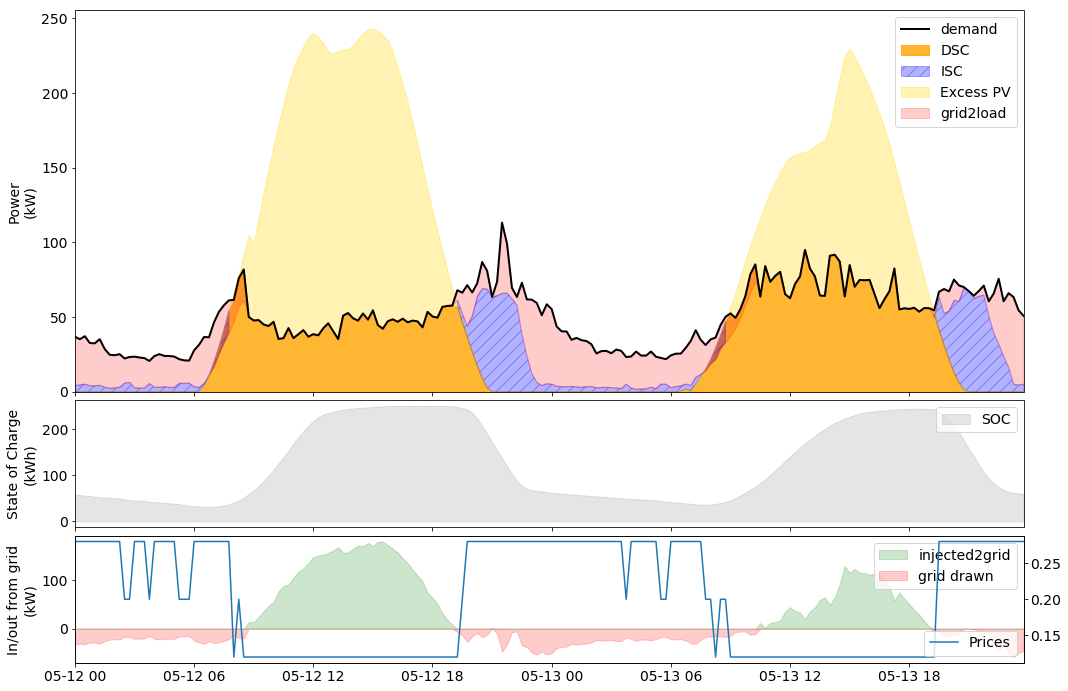

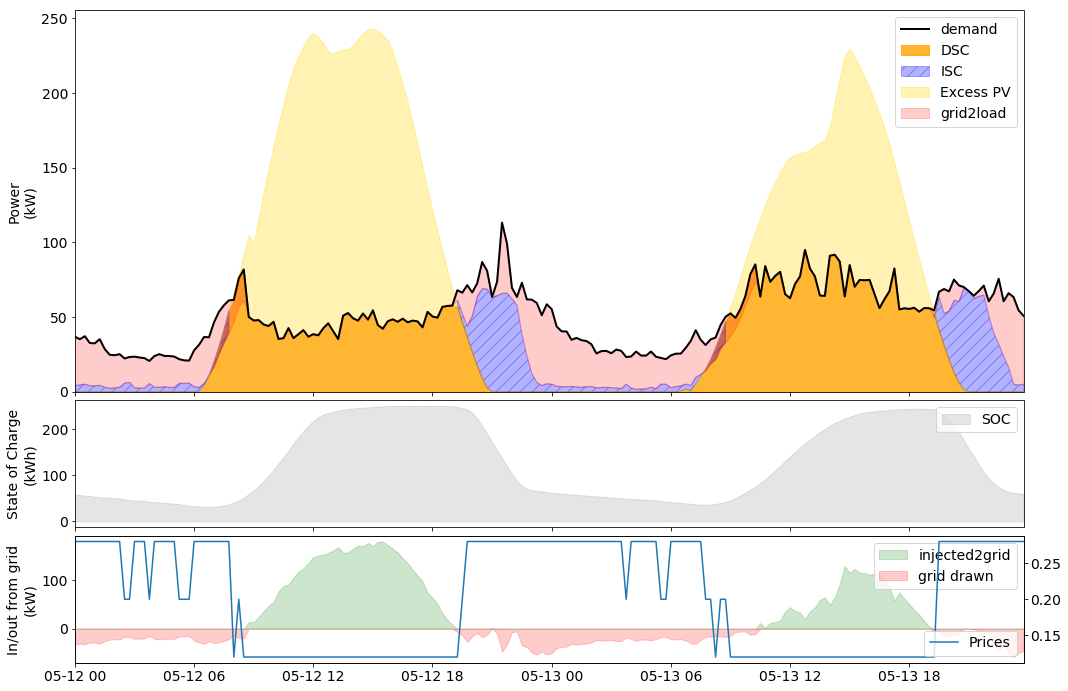

In [29]:
p2p.plot_dispatch_comm(comP2P.df_out.PV*comP2P.PV_size_comm, comP2P.df_out.loc[:,comP2P.df_com.iloc[:,0]].sum(axis=1),
                       comP2P.out_comm_final, week=20,flag=0,prices=comP2P.df_prices,save=False)

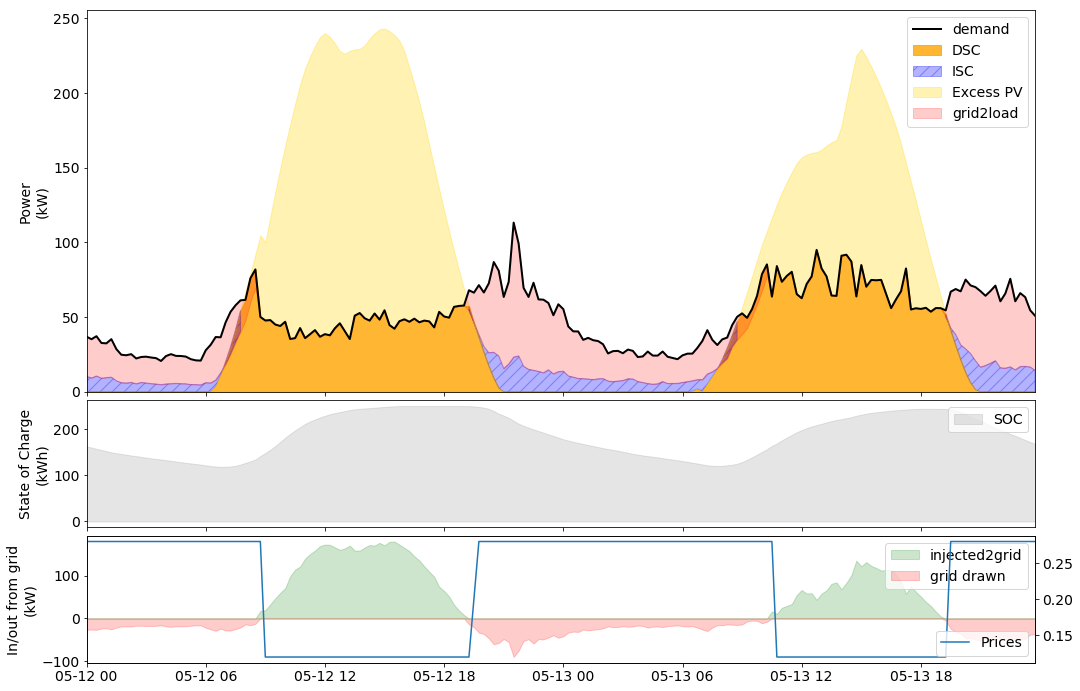

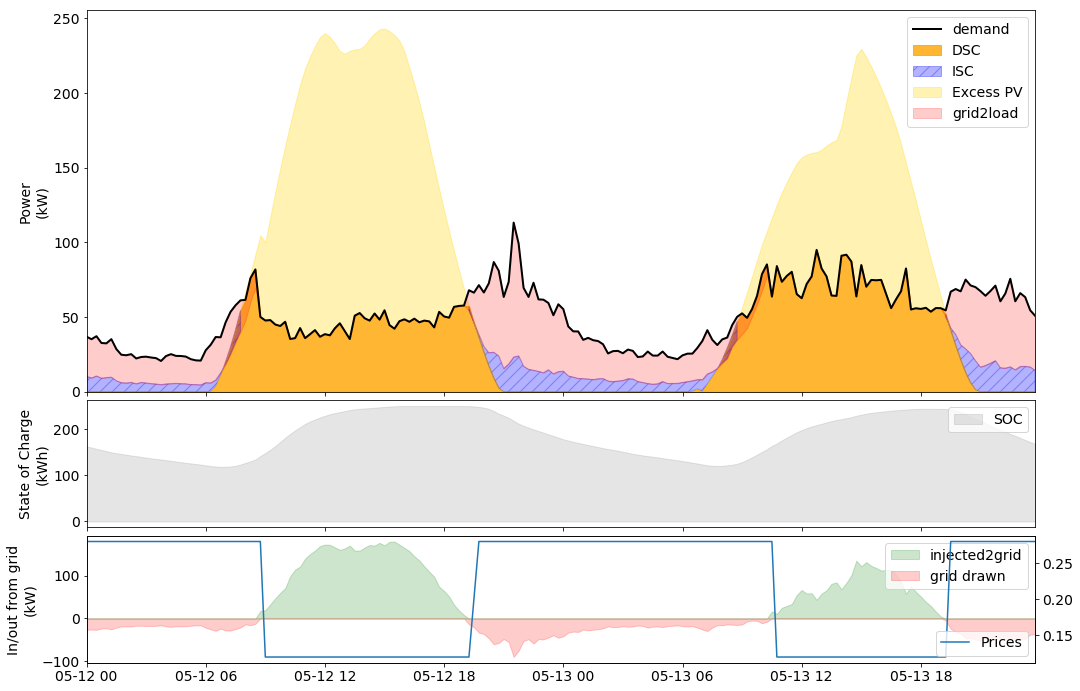

In [30]:
p2p.plot_dispatch_comm(comMod2.df_out.PV*comMod2.PV_size_comm, 
                               comMod2.df_out.loc[:,comMod2.df_com.iloc[:,0]].sum(axis=1),
                               comMod2.out_comm_final,prices=comMod2.df_prices, week=20)

In [109]:
comP2P.PV_size_comm

97.90000000000002

In [110]:
comMod2.PV_size_comm

311.00000000000006

In [119]:
sc=SCCommunity()

######################
Getting demand and PV profiles


In [120]:
sc.runAll()

----------------------------------
Country: DE
Data resolution: 15.0
Original year: 2010.0
Sample size: 74.0
Average consumption per year: 4685.069393693686
Country: DE
Total generation per year: PV    1535.83138
dtype: float64
Capacity factor: PV    17.53
dtype: float64%
######################
Getting PV distribution
Country: DE
0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

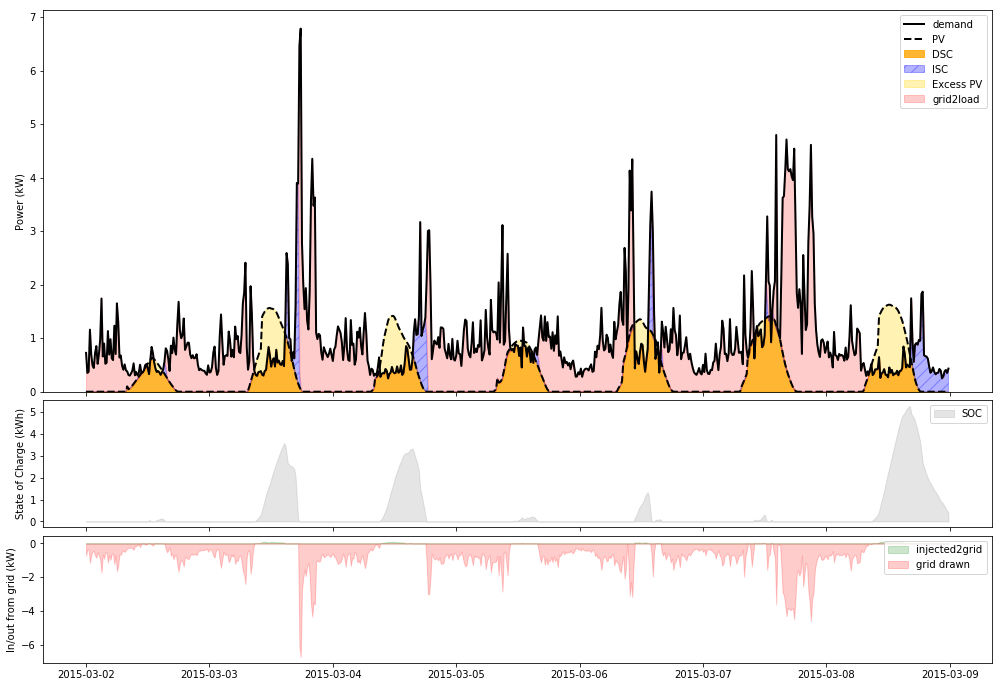

In [54]:
a,b=comMod.plotCommunity(hhNumber=50)

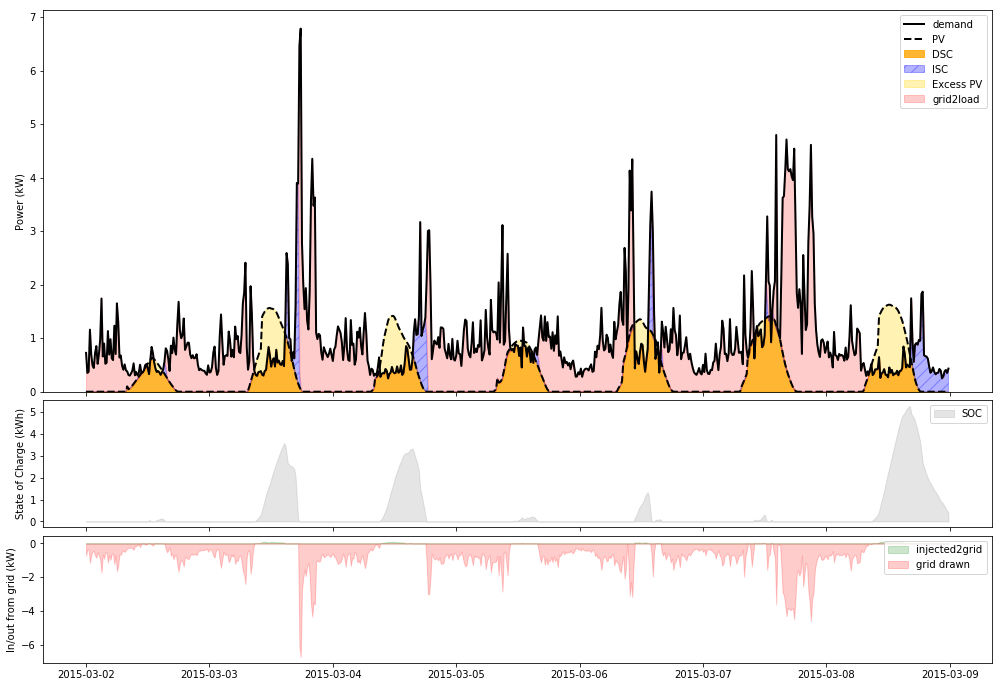

In [55]:
a,b=p_t.plotIndividual(hhNumber=50)